In [ ]:
import os
import pandas as pd
import kagglehub
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import gc
import sys
from pathlib import Path
import math
import json
import time
import wandb

# Navigate up to the project root and add it to sys.path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from data_loading.tools import reduce_mem_usage

OVERWRITE = False

In [8]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")
data_path = os.path.join(cache_path, "mryanm/luflow-network-intrusion-detection-data-set/versions/240")
curr_dir = os.getcwd()
src_dir = os.path.join(curr_dir, os.pardir)
combined_data_path = os.path.join(src_dir, os.pardir, "data", "luflow_combined.csv")

if not (os.path.exists(data_path) or os.path.exists(combined_data_path)) or OVERWRITE: # if either of the paths exist, don't download
    # Download latest version
    data_path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

if os.path.exists(combined_data_path) and not OVERWRITE:
    print(f"Combined data path: {combined_data_path}")
else:
    print(f"Data path: {data_path}")

Combined data path: /home/riley/networking_llm/src/eda/../../data/luflow_combined.csv


Data is in different folders seperated by year, month, and day. For ease of loading, I opted to combine these into a single csv.

In [9]:
def save_luflow(data_path, save_path):
    first_write = True  # Track if it's the first write to include headers

    # Load and combine each CSV
    for year in tqdm(sorted(os.listdir(data_path))):  # Sorting for consistency
        year_path = os.path.join(data_path, year)
        if os.path.isdir(year_path):
            for month in sorted(os.listdir(year_path)):
                month_path = os.path.join(year_path, month)
                if os.path.isdir(month_path):
                    for day in sorted(os.listdir(month_path)):
                        day_path = os.path.join(month_path, day)
                        if os.path.isdir(day_path):
                            for file in os.listdir(day_path):
                                if file.endswith(".csv"):
                                    full_path = os.path.join(day_path, file)

                                    # Read in chunks (adjust chunksize as needed)
                                    for chunk in pd.read_csv(full_path, chunksize=10_000):
                                        # Extract date info
                                        try:
                                            y, m, d = map(int, file.split(".")[:3])
                                            chunk["Year"] = y
                                            chunk["Month"] = m
                                            chunk["Day"] = d
                                            chunk['label'] = pd.Categorical(chunk['label']).codes
                                        except ValueError:
                                            print(f"Skipping malformed filename: {file}")
                                            continue

                                        # Append to file (write header only once)
                                        chunk.to_csv(save_path, mode='a', header=first_write, index=False)
                                        first_write = False  # Only write header in the first batch

    print(f"Finished merging CSVs into {save_path}")

if not os.path.exists(combined_data_path) or OVERWRITE:
    save_luflow(data_path, combined_data_path)
    # remove cache data_path
    os.system(f"rm -rf {data_path}")

In [75]:
data = pd.read_csv(combined_data_path, nrows=7_500_000)
data = reduce_mem_usage(data)
data.head()

Memory usage after optimization is: 443.46 MB
Decreased by 59.2%


/home/riley/networking_llm/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration,Year,Month,Day
0,7.500000,342,3679,786,9200.0,5.437500,2,2,6,786,57392.0,1592533725648144,1592533725632946,21860.917969,0,0.015198,2020,6,19
1,0.000000,0,0,786,55972.0,0.000000,1,1,6,49453,49493.0,1592533744644904,1592533744644904,0.000000,2,0.000000,2020,6,19
2,0.500000,15440,942,786,9300.0,2.203125,3,3,6,786,60512.0,1592533770936279,1592533770933553,36091.753906,0,0.002726,2020,6,19
3,20.217392,622,31010,786,9300.0,1.190430,23,5,6,786,60490.0,159253376770238,15925337672353,37640.355469,0,0.467041,2020,6,19
4,0.000000,0,0,786,59498.0,0.000000,1,1,6,786,9300.0,1592533772973114,1592533772973087,0.000000,0,0.000027,2020,6,19


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500000 entries, 0 to 7499999
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float32
 1   bytes_in       int32  
 2   bytes_out      int32  
 3   dest_ip        int32  
 4   dest_port      float32
 5   entropy        float16
 6   num_pkts_out   int16  
 7   num_pkts_in    int16  
 8   proto          int8   
 9   src_ip         int32  
 10  src_port       float32
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float32
 14  label          int8   
 15  duration       float16
 16  Year           int16  
 17  Month          int8   
 18  Day            int8   
dtypes: float16(2), float32(4), int16(3), int32(4), int64(2), int8(4)
memory usage: 443.5 MB


In [6]:
data['Day'].value_counts()

Day
22    4204081
21     814816
20     770853
19     765360
23     637677
24     307213
Name: count, dtype: int64

The full dataset is too large to get description stats in a timely manner, so only inspecting a subset. NaN seen for some mean values due to overflow during summation, a consequence of downcasting as we've done.

In [76]:
data.dest_port = data.dest_port.fillna(-1).astype('int64')
data.src_port = data.src_port.fillna(-1).astype('int64')

data.describe()

/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/networking_llm/lib/python3.10/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/home/riley/networking_llm/lib/python3.10/site-packages/numpy/_core/_methods.py:53: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riley/networking_llm/lib/python3.10/site-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid val

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration,Year,Month,Day
count,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7.500000e+06,7500000.0,7500000.0,7.500000e+06
mean,1.515988e+06,1.004937e+03,4.602249e+03,1.652941e+03,1.372595e+04,NaN,5.413012e+00,3.285689e+00,7.047596e+00,1.653160e+04,3.657185e+04,1.452405e+15,1.449253e+15,1.702605e+04,4.630831e-01,NaN,2020.0,6.0,2.154660e+01
std,4.287582e+07,4.473974e+03,6.907070e+03,8.210696e+03,1.606385e+04,0.000000e+00,1.262336e+01,1.204337e+01,3.440329e+00,3.993376e+04,1.859831e+04,4.286313e+14,4.328397e+14,6.049262e+04,7.219262e-01,0.000000e+00,0.0,0.0,1.217167e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,-1.000000e+00,1.592536e+10,1.592537e+10,0.000000e+00,0.000000e+00,0.000000e+00,2020.0,6.0,1.900000e+01
25%,0.000000e+00,0.000000e+00,4.700000e+01,7.860000e+02,1.900000e+03,2.035156e+00,1.000000e+00,0.000000e+00,6.000000e+00,7.860000e+02,1.430600e+04,1.592637e+15,1.592633e+15,9.736174e+02,0.000000e+00,4.297495e-05,2020.0,6.0,2.100000e+01
50%,0.000000e+00,0.000000e+00,3.670000e+02,7.860000e+02,9.200000e+03,3.089844e+00,3.000000e+00,1.000000e+00,6.000000e+00,7.860000e+02,4.446400e+04,1.592796e+15,1.592796e+15,8.341838e+03,0.000000e+00,1.149774e-04,2020.0,6.0,2.200000e+01
75%,4.500000e+00,2.700000e+02,8.688000e+03,7.860000e+02,9.200000e+03,4.832031e+00,7.000000e+00,3.000000e+00,6.000000e+00,8.048000e+03,4.910200e+04,1.592801e+15,1.592801e+15,2.654445e+04,1.000000e+00,2.381897e-02,2020.0,6.0,2.200000e+01
max,4.294967e+09,6.551200e+04,6.553400e+04,3.969980e+05,6.553500e+04,8.737500e+01,2.550000e+02,2.550000e+02,5.800000e+01,3.976510e+05,6.553500e+04,1.593015e+15,1.593015e+15,3.963484e+06,2.000000e+00,4.903125e+01,2020.0,6.0,2.400000e+01


In [77]:
cols_to_scale = ['avg_ipt', 'bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out']

0 = Benign, 1 = Malicious, 2 = Outlier

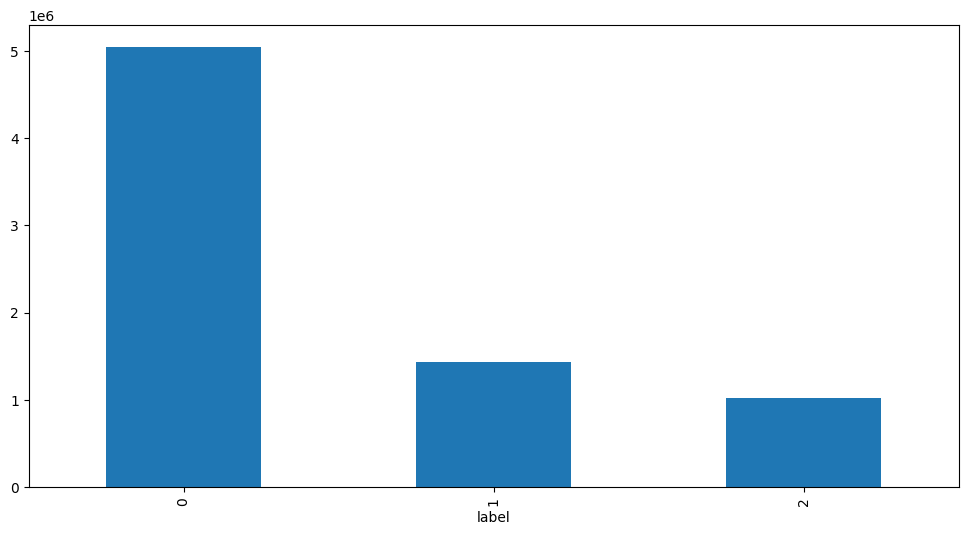

In [8]:
plt.figure(figsize=(12, 6))
data['label'].value_counts().plot(kind='bar')
plt.show()

Majority of flows use TCP (protocol 6)

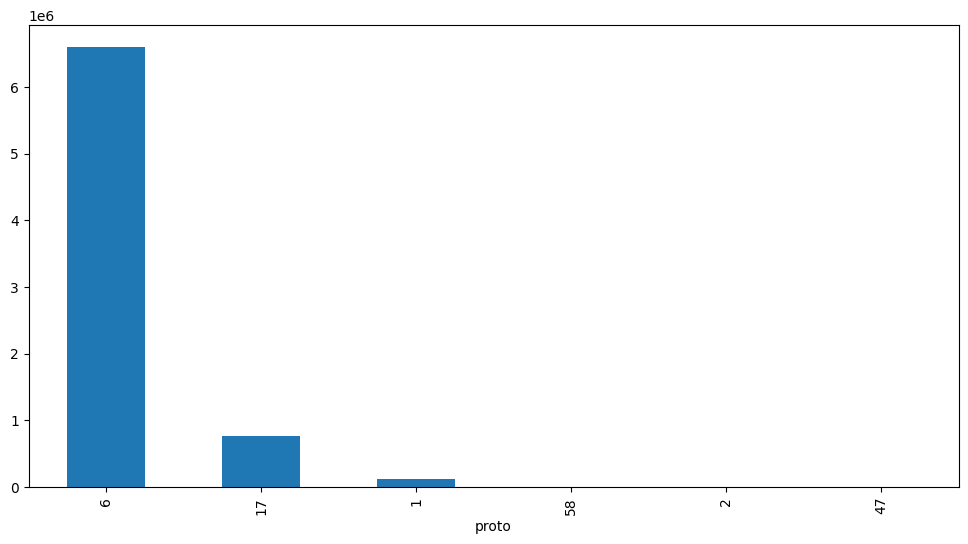

In [9]:
plt.figure(figsize=(12, 6))
data['proto'].value_counts().plot(kind='bar')
plt.show()

Columns to drop: src/dest_ip, time_start/end

In [78]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset

# Convert categorical features (proto) to numerical form
data_clean = pd.get_dummies(data, columns=['proto'], drop_first=True, dtype='int8')
data_clean.drop(['src_ip', 'dest_ip', 'time_start', 'time_end'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data_clean.drop(['label'], axis=1), data_clean['label'], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

X_train_normal = X_train[y_train == 0]
X_train_outliers = X_train[y_train == 1]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_normal.to_numpy(), dtype=torch.float32)
X_train, X_val = X_train[:int(0.8 * len(X_train))], X_train[int(0.8 * len(X_train)):]

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [79]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ELU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ELU(),
            nn.Linear(input_dim // 4, input_dim // 8),  # New layer
            nn.ELU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 8, input_dim // 4),  # New layer
            nn.ELU(),
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ELU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.ELU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
input_dim = X_train.shape[1]
model = Autoencoder(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [83]:
# Train the autoencoder
num_epochs = 10
log_interval = 10_000  # Print every 10K batches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    total_train_loss = 0
    batch_train_losses = []

    model.train()
    #for batch_idx, batch in enumerate(train_loader):
    for batch in tqdm(train_loader):
        data = batch[0].to(device)

        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)  # MSE loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        #batch_train_losses.append(loss.item())

        # Print loss every `log_interval` batches
        #if (batch_idx + 1) % log_interval == 0:
        #    print(f"Batch [{batch_idx+1}/{len(train_loader)}], Loss: {np.mean(batch_train_losses):.6f}")

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            total_val_loss += loss.item()

    epoch_val_loss = total_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

Epoch 1/10


100%|██████████| 101002/101002 [02:08<00:00, 784.36it/s]


Train Loss: 32426527.914645, Validation Loss: 32787114.996060
Epoch 2/10


100%|██████████| 101002/101002 [02:09<00:00, 780.40it/s]


Train Loss: 32413211.231891, Validation Loss: 32399259.539206
Epoch 3/10


 12%|█▏        | 12266/101002 [00:15<01:54, 777.11it/s]


KeyboardInterrupt: 

In [ ]:
# save model
torch.save(model.state_dict(), 'autoencoder.pth')

In [14]:
iso_forest = IsolationForest(n_estimators=100, max_samples=0.8, contamination=0.1, random_state=42, n_jobs=-1)

X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col], test_size=0.2, random_state=42)
X_train_normal = X_train[y_train == 0]
X_train_outliers = X_train[y_train == 1]

iso_forest.fit(X_train_normal)

IsolationForest(contamination=0.1, max_samples=0.8, n_jobs=-1, random_state=42)

In [17]:
iso_forest_preds = iso_forest.predict(X_test)
iso_forest_preds = np.where(iso_forest_preds == -1, 1, 0)
accuracy_score(y_test, iso_forest_preds)

0.7963413333333333

In [19]:
class LuFlowIterableDataset(IterableDataset):
    def __init__(self, csv_path, feature_cols, cat_cols, target_col, chunk_size=1000, train=True, train_ratio=0.8):
        self.csv_path = Path(csv_path)
        self.feature_cols = feature_cols
        self.cat_cols = cat_cols
        self.target_col = target_col
        self.chunk_size = chunk_size
        self.train = train
        self.train_ratio = train_ratio

        # Read header to verify columns
        print("Checking columns...")
        self.header = pd.read_csv(self.csv_path, nrows=0).columns
        df_sample = pd.read_csv(self.csv_path, nrows=1)
        missing_cols = set(feature_cols + [target_col]) - set(df_sample.columns)
        if missing_cols:
            raise ValueError(f"Missing columns in CSV: {missing_cols}")

        # Compute total rows
        if not hasattr(self, "total_rows"):
            print("Calculating total rows...")
            with open(csv_path, 'rb') as f:
                self.total_rows = sum(1 for _ in f) - 1  # -1 for header

        # Compute train/test split dynamically
        self.train_cutoff = int(self.total_rows * self.train_ratio)

        print("Computing embedding sizes...")
        self.num_embeddings = self._compute_categorical_sizes()

    def _compute_categorical_sizes(self):
        """Iterate over chunks to compute unique values for categorical features (cached)."""
        cache_file = self.csv_path.with_suffix('.cat_sizes.json')

        # Load from cache if exists
        if cache_file.exists():
            with open(cache_file, 'r') as f:
                return json.load(f)

        unique_values = {col: set() for col in self.cat_cols}
        total_chunks = math.ceil(self.total_rows / self.chunk_size)

        for chunk in tqdm(pd.read_csv(self.csv_path, chunksize=self.chunk_size, usecols=self.cat_cols), total=total_chunks):
            for col in self.cat_cols:
                unique_values[col].update(chunk[col].unique())

        num_embeddings = {col: len(values) for col, values in unique_values.items()}

        # Save to cache
        with open(cache_file, 'w') as f:
            json.dump(num_embeddings, f)

        return num_embeddings

    def __iter__(self):
        """Iterate over chunks, yielding rows dynamically."""
        for chunk in pd.read_csv(self.csv_path, chunksize=self.chunk_size):
            features = chunk[self.feature_cols].to_numpy(dtype=np.float32)
            cat_features = chunk[self.cat_cols].to_numpy(dtype=np.float32)
            target = chunk[self.target_col].to_numpy(dtype=np.float32).reshape(-1, 1)

            for i in range(len(chunk)):
                row_idx = i + (chunk.index[0] if chunk.index is not None else 0)
                
                # Dynamically filter train/test split
                if (self.train and row_idx < self.train_cutoff) or (not self.train and row_idx >= self.train_cutoff):
                    yield np.hstack([features[i], cat_features[i]]), target[i]

    def __len__(self):
        return self.total_rows

# Create datasets
train_dataset = LuFlowIterableDataset(
    csv_path=combined_data_path,
    feature_cols=feature_cols,
    cat_cols=['proto', 'src_port', 'dest_port'],
    target_col=target_col,
    train=True
)

test_dataset = LuFlowIterableDataset(
    csv_path=combined_data_path,
    feature_cols=feature_cols,
    cat_cols=['proto', 'src_port', 'dest_port'],
    target_col=target_col,
    train=False
)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

# Test
for batch in train_dataloader:
    inputs, labels = batch
    print(f"Sample input: {inputs[0]}")
    print(f"Sample label: {labels[0]}")
    print(inputs.shape, labels.shape)
    break

Checking columns...
Calculating total rows...
Computing embedding sizes...
Checking columns...
Calculating total rows...
Computing embedding sizes...
Sample input: tensor([7.5000e+00, 3.4200e+02, 3.6790e+03, 9.2000e+03, 5.4367e+00, 2.0000e+00,
        2.0000e+00, 6.0000e+00, 5.7392e+04, 2.1861e+04, 1.5198e-02, 2.0200e+03,
        6.0000e+00, 1.9000e+01, 6.0000e+00, 5.7392e+04, 9.2000e+03])
Sample label: tensor([0.])
torch.Size([64, 17]) torch.Size([64, 1])


From the GitHub https://github.com/ruzzzzz/luflow

#### src_ip:
The source IP address associated with the flow. This feature is anonymised to the corresponding Autonomous System

#### src_port:
The source port number associated with the flow.

#### dest_ip:
The destination IP address associated with the flow. The feature is also anonymised in the same manner as before.

#### dest_port:
The destination port number associated with the flow

#### protocol:
The protocol number associated with the flow. For example TCP is 6

#### bytes_in:
The number of bytes transmitted from source to destination

#### bytes_out:
The number of bytes transmitted from destination to source.

#### num_pkts_in:
The packet count from source to destination

#### num_pkts_out:
The packet count from destination to source

#### entropy:
The entropy in bits per byte of the data fields within the flow. This number ranges from 0 to 8.

#### total_entropy:
The total entropy in bytes over all of the bytes in the data fields of the flow

#### avg_ipt:
The mean of the inter-packet arrival times of the flow

#### time_start:
The start time of the flow in seconds since the epoch.

#### time_end:
The end time of the flow in seconds since the epoch

#### duration:
The flow duration time, with microsecond precision

#### label:
The label of the flow, as decided by Tangerine. Either benign, outlier, or malicious

Datasets from https://staff.itee.uq.edu.au/marius/NIDS_datasets/#RA6

### Modeling

In [13]:
# Dynamically compute embedding dimensions
def compute_embedding_dim(num_categories):
    return min(50, max(1, int(num_categories ** 0.25)))

In [20]:
class NetworkDetectionModel(nn.Module):
    def __init__(self, output_dim, num_embeddings):
        super().__init__()
        
        # Extract categorical feature sizes
        num_proto = num_embeddings['proto']
        num_src_port = num_embeddings['src_port']
        num_dest_port = num_embeddings['dest_port']

        # Compute embedding dimensions
        embed_dim_proto = compute_embedding_dim(num_proto)
        embed_dim_src_port = compute_embedding_dim(num_src_port)
        embed_dim_dest_port = compute_embedding_dim(num_dest_port)

        # Define embedding layers
        self.proto_embed = nn.Embedding(num_embeddings=num_proto, embedding_dim=embed_dim_proto)
        self.src_port_embed = nn.Embedding(num_embeddings=num_src_port, embedding_dim=embed_dim_src_port)
        self.dest_port_embed = nn.Embedding(num_embeddings=num_dest_port, embedding_dim=embed_dim_dest_port)

        # Compute input dimension
        self.input_dim = 6 + embed_dim_proto + embed_dim_src_port + embed_dim_dest_port
        self.hidden_dim = int(math.ceil((self.input_dim + 1) * 0.67))

        # Define network layers
        self.linear_1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.linear_2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.out = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, x):
        # Extract continuous and categorical features
        continuous_features = x[:, :6]
        proto = x[:, 6].to(torch.long)
        src_port = x[:, 7].to(torch.long)
        dest_port = x[:, 8].to(torch.long)

        # Apply embeddings
        proto = self.proto_embed(proto)
        src_port = self.src_port_embed(src_port)
        dest_port = self.dest_port_embed(dest_port)

        # Concatenate embeddings with continuous features
        x = torch.cat([continuous_features, proto, src_port, dest_port], dim=-1)
        
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        x = self.out(x)

        return x

In [24]:
class TrainingProgressTracker:
    def __init__(self, num_epochs, steps_per_epoch, log_interval=10, use_wandb=False):
        self.num_epochs = num_epochs
        self.steps_per_epoch = steps_per_epoch
        self.log_interval = log_interval
        self.use_wandb = use_wandb
        self.reset_epoch_stats()
        
    def reset_epoch_stats(self):
        self.running_loss = 0.0
        self.correct = 0
        self.total = 0
        self.batch_times = []
        self.epoch_start_time = time.time()
        
    def update_stats(self, loss, predictions, targets, batch_size):
        self.running_loss += loss
        self.correct += (predictions == targets).sum().item()
        self.total += batch_size
        
    def log_progress(self, epoch, step):
        if step % self.log_interval == 0:
            avg_loss = self.running_loss / (step + 1)
            accuracy = (self.correct / self.total) * 100
            elapsed = time.time() - self.epoch_start_time
            remaining = (elapsed / (step + 1)) * (self.steps_per_epoch - step - 1)
            
            print(f"\rEpoch [{epoch+1}/{self.num_epochs}] "
                  f"Step [{step+1}/{self.steps_per_epoch}] "
                  f"Loss: {avg_loss:.4f} "
                  f"Accuracy: {accuracy:.2f}% "
                  f"Elapsed: {elapsed:.1f}s "
                  f"Remaining: {remaining:.1f}s", end="")
            
            if self.use_wandb:
                wandb.log({
                    "train/loss": avg_loss,
                    "train/accuracy": accuracy,
                    "train/epoch": epoch,
                    "train/step": step
                })

def train_model(model, train_dataloader, test_dataloader, num_epochs, device, 
                learning_rate=0.001, use_wandb=False, checkpoint_dir="checkpoints"):
    
    # Setup
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.amp.GradScaler()
    
    # Initialize progress tracker
    steps_per_epoch = len(train_dataloader)
    tracker = TrainingProgressTracker(num_epochs, steps_per_epoch, use_wandb=use_wandb)
    
    # Optional: Configure automatic mixed precision
    torch.backends.cudnn.benchmark = True  # May speed up training
    
    # Training loop with checkpointing
    best_accuracy = 0.0
    for epoch in range(num_epochs):
        model.train()
        tracker.reset_epoch_stats()
        
        # Use tqdm for overall epoch progress
        for step, batch in enumerate(train_dataloader):
            batch_start = time.time()
            
            features, targets = batch
            features = features.to(device, non_blocking=True)
            targets = targets.to(device, dtype=torch.long, non_blocking=True)
            
            # Forward pass with mixed precision
            with torch.amp.autocast(device_type=str(device)):
                outputs = model(features)
                loss = criterion(outputs, targets.squeeze())
            
            # Backward pass with gradient scaling
            optimizer.zero_grad(set_to_none=True)  # Slightly faster than zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Update statistics
            with torch.no_grad():
                _, predictions = torch.max(outputs, 1)
                tracker.update_stats(loss.item(), predictions, targets.squeeze(), targets.size(0))
                tracker.log_progress(epoch, step)
            
            # Record batch processing time
            tracker.batch_times.append(time.time() - batch_start)
        
        # End of epoch
        avg_loss = tracker.running_loss / len(train_dataloader)
        accuracy = tracker.correct / tracker.total * 100
        avg_batch_time = np.mean(tracker.batch_times)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Accuracy: {accuracy:.2f}%")
        print(f"Average batch processing time: {avg_batch_time:.3f}s")
        
        # Save checkpoint if best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            checkpoint_path = checkpoint_dir / f"best_model_epoch_{epoch+1}.pt"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
                'loss': avg_loss,
            }, checkpoint_path)
            print(f"Saved new best model checkpoint to {checkpoint_path}")

num_epochs = 10
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = NetworkDetectionModel(output_dim=3, num_embeddings=train_dataset.num_embeddings).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scaler = torch.amp.GradScaler()  # Handles scaling to prevent underflow

# Usage example:
train_model(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_epochs=num_epochs,
    device=device,
    learning_rate=learning_rate,
    use_wandb=False  # Set to True if using Weights & Biases
)

Using device: cuda
Epoch [1/10] Step [33681/3227447] Loss: nan Accuracy: 48.26% Elapsed: 67.8s Remaining: 6433.1s

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Network_Detection_Model(
    output_dim=1,
    embed_dim_bin=4, num_bin=2,
    embed_dim_bout=4, num_bout=2,
    embed_dim_pin=4, num_pin=2,
    embed_dim_pout=4, num_pout=2,
    embed_dim_proto=4, num_proto=2
).to(device)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network_Dection_Model(1, 10, 10, 10, 10, 10, 10, 10, 10, 10)
model.to(device)


'''shrink = int(len(data[0])/10)
print(shrink)
data = data[:, :shrink]

print(data.shape)'''

###Finish loading data###

def save_scalers(scalers, save_dir='./scalers/'):
    """
    Save all scalers to pickle files.
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save scalers
    for i, scaler in enumerate(scalers):
        with open(f'{save_dir}X1_scaler_{H.continuous_variables[i]}.pkl', 'wb') as f:
            pickle.dump(scaler, f)

### Make train test split ###
# Transpose to make it (samples, features) for sklearn
data_transposed = data.T

# Split with random state for reproducibility
train_transposed, test_transposed = train_test_split(
    data_transposed, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

# Transpose back to original orientation (features, samples)
train = train_transposed.T
test = test_transposed.T

#Save test tensor for testing the model inference
torch.save(test, U.test_data)

#Turn into numpy arrays for sklearn
train = train.numpy()
test = test.numpy()

### Scale Continuous Variables ###
train_scalers = [] #Store scalars to be saved and used on new data
for index in range(4):
    scaler = MinMaxScaler(feature_range=(-1, 1))  # Create a new scaler
    train[index] = scaler.fit_transform(train[index].reshape(-1, 1)).flatten()
    test[index] = scaler.transform(test[index].reshape(-1, 1)).flatten()
    train_scalers.append(scaler)

save_scalers(train_scalers)

#Turn back into tensors
train = torch.from_numpy(train.astype(np.float32))
test = torch.from_numpy(test.astype(np.float32))

check_feature = 4
print(train[check_feature, torch.argmin(train[check_feature])], train[check_feature, torch.argmax(train[check_feature])])

print(f'min: {train[check_feature, torch.argmin(train[check_feature])]}, max: {train[check_feature, torch.argmax(train[check_feature])]}')

### Make Dataset ###
Train_Dataset = D.LUFlow_ND_Dataset(train)
Test_Dataset = D.LUFlow_ND_Dataset(test)

### Map Values ###
print("Mapping values")
feature_map_bin, feature_map_bout, feature_map_proto, original_bin, original_bout = preprocessing_functions.map_values(Train_Dataset)

with open(U.feature_map_bin, 'w') as j:
    json.dump(feature_map_bin, j, indent=4)
with open(U.feature_map_bout, 'w') as j:
    json.dump(feature_map_bout, j, indent=4)
with open(U.feature_map_proto, 'w') as j:
    json.dump(feature_map_proto, j, indent=4)

# Explicitly assign back to ensure updates stick
Train_Dataset.data[4, :] = torch.tensor([feature_map_bin[str(int(val.item()))] for val in Train_Dataset.data[4, :]])
Train_Dataset.data[5, :] = torch.tensor([feature_map_bout[str(int(val.item()))] for val in Train_Dataset.data[5, :]])
Train_Dataset.data[8, :] = torch.tensor([feature_map_proto[str(int(val.item()))] for val in Train_Dataset.data[8, :]])
print(f'1: {Train_Dataset.data[4, torch.argmax(Train_Dataset.data[4])]}')
print(f'2: {original_bin[torch.argmax(original_bin)]}')

torch.save(Train_Dataset, U.training_dataset)

### Map Test Values ###
for i, item in enumerate(Test_Dataset.data[4]): #For bin
    Test_Dataset.data[4, i] = preprocessing_functions.approximate_value(item, original_bin)

### Map Test Values ###
for i, item in enumerate(Test_Dataset.data[5]): #For bout
    Test_Dataset.data[5, i] = preprocessing_functions.approximate_value(item, original_bout)

# Explicitly assign back to ensure updates stick
Test_Dataset.data[4, :] = torch.tensor([feature_map_bin[str(int(val.item()))] for val in Test_Dataset.data[4, :]])
Test_Dataset.data[5, :] = torch.tensor([feature_map_bout[str(int(val.item()))] for val in Test_Dataset.data[5, :]])
Test_Dataset.data[8, :] = torch.tensor([feature_map_proto[str(int(val.item()))] for val in Test_Dataset.data[8, :]])

### Initialize Dataloaders ###
Train_Loader = DataLoader(Train_Dataset, batch_size=H.BATCH_SIZE, shuffle=True)
Test_Loader = DataLoader(Test_Dataset, batch_size=H.BATCH_SIZE, shuffle=False)

### Model Initialization ###
############################
### Calculate Embedding Layer Sizes ###
embed_dims = []
num_embeds = []

print("Calculating embedding dims")
for i in range(4, 9):
    print(i)
    feature = Train_Dataset.__getfeature__(i)
    #print(feature[torch.argmin(feature)], feature[torch.argmax(feature)])
    num_features = feature[torch.argmax(feature)].item()
    print(num_features)

    embed_dims.append(int(math.floor(math.sqrt(num_features+1))))
    num_embeds.append(int(num_features)+1)

print("Embedding parameters")
print(f'embed_dims: {embed_dims}')
print(f'num_embeds: {num_embeds}')

model = Model.Network_Dection_Model(H.OUTPUT_DIM, #'avg_ipt', 'entropy', 'total_entropy', 'duration', 1 output neuron
                                    embed_dims[0], num_embeds[0], #Bin
                                    embed_dims[1], num_embeds[1], #Bout
                                    embed_dims[2], num_embeds[2], #Pin
                                    embed_dims[3], num_embeds[3], #Pout
                                    embed_dims[4], num_embeds[4]) #Proto
model.to(device)
#Save model parameters for loading before inference
model_params = {'output': H.OUTPUT_DIM, 
                'embed_dims': embed_dims,
                'num_embeds': num_embeds,
                'original_bin': original_bin.tolist(),
                'original_bout': original_bout.tolist(),
                'feature_map_bin': feature_map_bin,
                'feature_map_bout': feature_map_bout,
                'feature_map_proto': feature_map_proto}

with open(U.model_params, 'w') as j: #Save model parameters
    json.dump(model_params, j, indent=4)

loss_fn = nn.CrossEntropyLoss() #Binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=H.LEARNING_RATE)

#Accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

#Training Loop
train_losses = []
val_losses = []

best_val_loss = float('inf')  # Initialize best validation loss as infinity
epochs_no_improve = 0

percentage_update = .25
update = int(len(Train_Loader) * percentage_update)
amt = 0

for epoch in range(H.EPOCHS):
    print(f"=== EPOCH {epoch + 1} ===")
    model.train()
    training_loss = 0 #Track training loss across that batches
    print("Running Training Loop")
    for i, batch in enumerate(Train_Loader):
        #Forward Pass
        x = batch[:, :9]
        y = batch[:, 9].to(torch.long)
        #Send to device
        x = x.to(device)
        y = y.to(device)

        y_preds = model(x)
        y_preds = y_preds.squeeze(1)

        #Loss
        loss = loss_fn(y_preds, y)
        training_loss += loss.item()

        #Back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%update == 0:
            amt += 1
            #print(f'{percentage_update*amt}%')

    training_loss /= len(Train_Loader)
    train_losses.append(training_loss)

    testing_loss, test_acc = 0, 0
    print("Testing the model...")
    model.eval()
    for batch in Test_Loader:
        #Forward Pass
        x = batch[:, :9]
        y = batch[:, 9].to(torch.long)

        #Send to device
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_preds = model(x)

        y_preds = y_preds.squeeze(1)

        #Loss
        loss = loss_fn(y_preds, y)
        testing_loss += loss.item()

        test_acc += accuracy_fn(y_true=y, y_pred=y_preds.argmax(dim=1))
    
    testing_loss /= len(Test_Loader)
    test_acc /= len(Test_Loader)
    val_losses.append(testing_loss)
    print(f"Train loss: {training_loss:.6f} | Test loss: {testing_loss:.6f} | Test acc: {test_acc:.6f}%")

    #Evaluate model
    if testing_loss < best_val_loss:
        best_val_loss = testing_loss
        # Save the model's parameters (state_dict) to a file
        torch.save(model.state_dict(), (U.MODEL_FOLDER / (H.MODEL_NAME + '.pth')).resolve())
        with open((U.MODEL_FOLDER / (H.MODEL_NAME + '_loss.txt')).resolve(), 'w') as f:
            f.write(str(testing_loss))
        print(f'Saved best model with validation loss: {best_val_loss:.6f}')
        epochs_no_improve = 0  # Reset counter if improvement
    else:
        epochs_no_improve += 1
        print(f'Num epochs since improvement: {epochs_no_improve}')

        #stop training if overfitting starts to happen
        if epochs_no_improve >= H.PATIENCE:
            print("Early stopping")
            break

for x in range(H.PATIENCE):
    train_losses.pop(-1)
    val_losses.pop(-1)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()